In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

from bioemu.observables.folding_stability import compute_folded_proportion_from_dG
from datasets import DatasetDict, load_dataset

seed = 42  # Set a seed for reproducibility

In [ ]:
# 1. Load your dataset
dataset_tag = "dataset2"
dataset2 = load_dataset(
    path="RosettaCommons/MegaScale", name=dataset_tag, data_dir=dataset_tag
)

# 2. First split: 80% train / 20% (val + test)
train_testvalid = dataset2["train"].train_test_split(test_size=0.2, seed=42)

# 3. Second split: split that 20% into two equal parts (10% each)
test_valid = train_testvalid["test"].train_test_split(test_size=0.5, seed=42)

# 4. Build the final DatasetDict
dataset2_splits = DatasetDict(
    {
        "train": train_testvalid["train"],  # 80%
        "val": test_valid["train"],  # 10%
        "test": test_valid["test"],  # 10%
    }
)

In [ ]:
os.makedirs("datasets/megascale", exist_ok=True)

dataset2_splits["train"].to_csv("datasets/megascale/train.csv")
dataset2_splits["val"].to_csv("datasets/megascale/val.csv")
dataset2_splits["test"].to_csv("datasets/megascale/test.csv")

In [2]:
train = pd.read_csv("datasets/megascale/train.csv")
val = pd.read_csv("datasets/megascale/val.csv")
test = pd.read_csv("datasets/megascale/test.csv")

# convert dG_ML to float and fileter out values that are not numbers
train["dG_ML"] = pd.to_numeric(train["dG_ML"], errors="coerce")
val["dG_ML"] = pd.to_numeric(val["dG_ML"], errors="coerce")
test["dG_ML"] = pd.to_numeric(test["dG_ML"], errors="coerce")
# filter out rows with NaN dG_ML
train = train.dropna(subset=["dG_ML"])
val = val.dropna(subset=["dG_ML"])
test = test.dropna(subset=["dG_ML"])

# compute the correct dG_ML values
train["dG_ML"] = -train["dG_ML"]
val["dG_ML"] = -val["dG_ML"]
test["dG_ML"] = -test["dG_ML"]
# compute the proportion of folded sequences based on dG_ML
train["p_folded"] = compute_folded_proportion_from_dG(
    torch.tensor(train["dG_ML"].to_numpy())
).numpy()
val["p_folded"] = compute_folded_proportion_from_dG(
    torch.tensor(val["dG_ML"].to_numpy())
).numpy()
test["p_folded"] = compute_folded_proportion_from_dG(
    torch.tensor(test["dG_ML"].to_numpy())
).numpy()
# add all-zero column
train["zeros"] = 0.0
val["zeros"] = 0.0
test["zeros"] = 0.0
# add all-one column
train["ones"] = 1.0
val["ones"] = 1.0
test["ones"] = 1.0

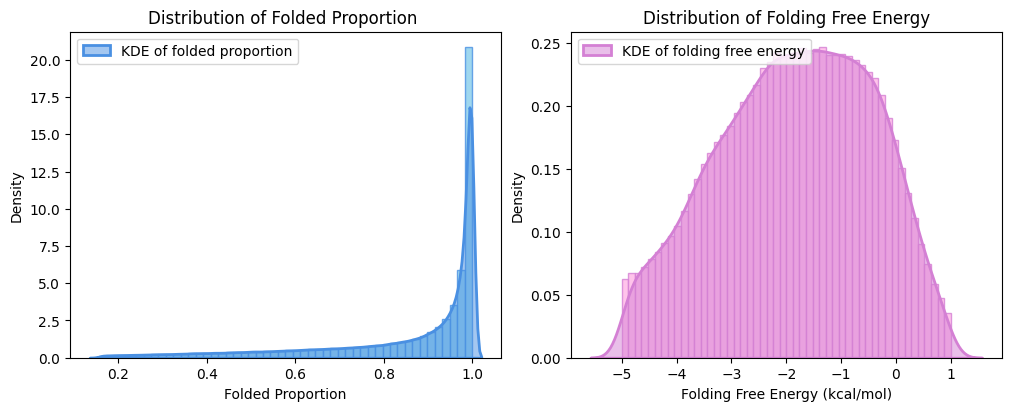

In [3]:
datatset_total = pd.concat([train, val, test], ignore_index=True)


colors = {
    "h_star": "#4A90E2",  # blue for h_star
    "h_func": "#87CEEB",  # sky blue for h_func
    "delta_G_star": "#D480D4",  # pinker purple for delta_G_star
    "delta_G": "#FFB6E6",  # light pink for delta_G
}

fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
ax[0].hist(
    datatset_total["p_folded"],
    bins=50,
    density=True,
    alpha=0.8,
    color=colors["h_func"],
    edgecolor=colors["h_star"],
    linewidth=1,
)
sns.kdeplot(
    datatset_total["p_folded"],
    ax=ax[0],
    color=colors["h_star"],
    linewidth=2,
    label="KDE of folded proportion",
    fill=True,
    alpha=0.5,
    bw_adjust=0.5,  # Adjust bandwidth for smoother KDE
    common_norm=False,  # Normalize each distribution separately
    linestyle="-",
)

ax[1].hist(
    datatset_total["dG_ML"],
    bins=50,
    density=True,
    alpha=0.8,
    color=colors["delta_G"],
    edgecolor=colors["delta_G_star"],
    linewidth=1,
)
sns.kdeplot(
    datatset_total["dG_ML"].values,
    ax=ax[1],
    color=colors["delta_G_star"],
    linewidth=2,
    label="KDE of folding free energy",
    fill=True,
    alpha=0.5,
    bw_adjust=2,  # Adjust bandwidth for smoother KDE
    common_norm=False,  # Normalize each distribution separately
    linestyle="-",
)
ax[0].set_title("Distribution of Folded Proportion ")
ax[0].set_xlabel("Folded Proportion")
ax[0].set_ylabel("Density")
ax[1].set_title("Distribution of Folding Free Energy")
ax[1].set_xlabel("Folding Free Energy (kcal/mol)")
ax[1].set_ylabel("Density")
ax[0].legend(loc="upper left")
ax[1].legend(loc="upper left")

plt.show()

In [ ]:
# randomly sample 5 sequences from train with dG_ML from -4 to 1,
# and 1 sequence from val
# sequences should be shorter than 50 amino acids
train_sample_1 = train[
    (train["aa_seq"].str.len() < 50) & (train["dG_ML"] >= -4) & (train["dG_ML"] < -3)
].sample(n=1, random_state=seed)
train_sample_2 = train[
    (train["aa_seq"].str.len() < 50) & (train["dG_ML"] >= -3) & (train["dG_ML"] < -2)
].sample(n=1, random_state=seed)
train_sample_3 = train[
    (train["aa_seq"].str.len() < 50) & (train["dG_ML"] >= -2) & (train["dG_ML"] < -1)
].sample(n=1, random_state=seed)
train_sample_4 = train[
    (train["aa_seq"].str.len() < 50) & (train["dG_ML"] >= -1) & (train["dG_ML"] < 0)
].sample(n=1, random_state=seed)
train_sample_5 = train[
    (train["aa_seq"].str.len() < 50) & (train["dG_ML"] >= 0) & (train["dG_ML"] < 1)
].sample(n=1, random_state=seed)
train_sample = pd.concat(
    [
        train_sample_1,
        train_sample_2,
        train_sample_3,
        train_sample_4,
        train_sample_5,
    ]
)
val_sample = val[(val["aa_seq"].str.len() < 50) & (val["dG_ML"] < 1)].sample(
    n=1, random_state=seed
)
train_sample

In [ ]:
# save the samples
os.makedirs("test/megascale", exist_ok=True)
train_sample.to_csv("test/megascale/train_sample.csv", index=False)
val_sample.to_csv("test/megascale/val_sample.csv", index=False)
# save the merged samples
merged_sample = pd.concat([train_sample, val_sample], ignore_index=True)
merged_sample.to_csv("test/megascale/dataset.csv", index=False)